## Plagiarism Detector Implementation with CBF 

In [85]:
from collections import deque
import math
from typing import List
from requests import get

class CountingBloomFilter:
    """
    Implements the Counting Bloom Filter which supports:
    
    - search: queries the membership of an element
    - insert: inserts a string to the filter
    - delete: removes a string from the filter
    - hash_cbf: calculating hash values for the elements inserted
    - compute_cbf_arr: 
    """
    def __init__(self, num_item: int, fpr: float):
        """
        This is a Counting Bloom Filter class that stores the information about the main aspects of CBF: 
        input size, and false positive rate that can be further used to find memory size, initialize bit 
        array, find number of hash functions.
        
        Attributes
        ----------
        num_item : integer
            number of elements in Counting Bloom Filter, corresponding to the parameter num_item.
        fpr : float
            false positive rate of Counting Bloom Filter, corresponding to the parameter fpr.
        memory_size : integer
            length of bit array of Counting Bloom Filter, corresponding to the parameter memory_size.
        cbf_array : list
            initialized bit array of Counting Bloom Filter, corresponding to the parameter fpr.
        num_hashfn : integer
            number of hash functions, corresponding to the parameter num_hashfn.
        prime_list : list 
            list of prime numbers used for CBF, corresponding to the parameter prime_list
        primes : list
            list of primes numbers used for calculating hash values based on number of hash functions
        """
        self.num_item = num_item
        self.fpr = fpr 
        self.memory_size = -1*round((self.num_item * math.log(self.fpr))/(math.log(2))**2) #formula for computing memory_size
        self.cbf_array = [0] * self.memory_size #initializing bit array
        self.num_hashfn = int(round(self.memory_size/self.num_item)*math.log(2))
        self.num_hashfn = min(10, self.num_hashfn) 
        self.prime_list = [127, 149, 179, 197, 233, 257, 283, 313, 379, 401]
        self.primes = self.prime_list[:self.num_hashfn]  #choosing the appropriate number of primes based on the number of hash functions

        
    def hash_cbf(self, item: str):
        """
        Finding the hash values of the item based on the given primes by finding unicode of each character of 
        the string with ord() and using primes as bases. 
    
        Parameters
        ----------
        item: string
            String for which we will be computing k hash values based on k hash functions

        Returns
        ----------
        List
            List containing different hash values of one string depending on the number of hash functions used, 
            and therefore, depending on the number of primes used. 

        """

        hash_indices = [] 
        
        for prime_num in self.primes:
            char_hash = 0
            string_hash = 0
            
            for char in range(len(item)):
                char_hash = ord(item[char]) * (prime_num ** (len(item)- char-1)) #hash value of one character
                string_hash = string_hash + char_hash  #hash value of the whole string

            hash_indices.append(string_hash % self.memory_size)
        return hash_indices



    def compute_cbf_arr(self, text: List[str], window_size: int):
        """
        Uses a deque to create a window of the specified size and computes the hash values of each of the string. 
        The function then adds the computed hash values to the array and increment values at index positions 

        Parameters
        ----------
        text: list
            list of strings that will be used for creating windows to compute hash values 
            
        window_size: int
            integer that represents the sliding window size; number of strings in the window

        Returns
        ----------
        None

        """
          
        cur_window = deque()
        end = 0

        while end < len(text): 
            
            #continue appending strings into the current window until it reaches the desired number 
            # of strings (windows size)
            
            while len(cur_window) < window_size: 
                cur_window.append(text[end])
                end += 1
            
            cur_word = "".join(cur_window) #join several strings into one
            hash_idxs = self.hash_cbf(cur_word)  

            for idx in hash_idxs:
                self.cbf_array[idx] += 1

            #removing the leftmost element in the window --> first string 
            cur_window.popleft()
            


    def search(self, input_word: str) -> bool:
        """
        Searches for the given input word in the Counting Bloom Filter (CBF) array by checking indices that 
        correspond to the computed hash values. 

        Parameters:
        ----------
        input_word: str
            The word/phrase to search for in the CBF array. 

        Returns: 
        ----------
        bool: 
            True if the word is found, False otherwise. 
            True occurs when all the values at index positions are greater than 0, False occurs when one of the 
            values at index positions (hash values) is equal to 0. 

        """
        indices = self.hash_cbf("".join(input_word)) 
        #print("".join(input_word))
        count = len(indices)
        
        for index in indices: 
            if self.cbf_array[index] == 0:
                return False
            else:
                count -= 1
        return count == 0 #return True when all of the indices are checked 

    
    def insert(self, item: str):
        """
        Inserts a given item into the Counting Bloom Filter (CBF) array by finding indices that correspond
        to computed hash values and incrementing the values found at those indices by 1. 

        Parameters:
        ----------
        item: str 
            The string we will insert into the CBF array with the use of computed hash values. 

        Returns:
        ----------
        self.cbf_array: List[int]: 
            The updated CBF array where indices corresponding to hash values 
            have the buckets incremented by 1.
            
        """

        indeces = self.hash_cbf(item) 

        for index in indeces: #for each of the hash value in the list
            self.cbf_array[index] += 1 #find the index that corresponds to the hashvalue and increment by 1
        return self.cbf_array
        

    def delete(self, item: str):
        """
        Deletes a given item from the Counting Bloom Filter (CBF) array by by finding indices that correspond
        to computed hash values of item and decrementing the values found at those indices by 1. 

        Parameters:
        ----------
        item: str
            The item we need to delete from the CBF array. 

        Raises KeyError: 
        If the item is not found in the CBF array. 

        Returns:
        ----------
        None 
        """
        if self.search(item):
            indeces = self.hash_cbf(item) 

            for index in indeces: 
                self.cbf_array[index] -= 1 #find the index that corresponds to the hashvalue and decrement by 1
        else:
            raise KeyError(f'The item {item} you are searching for is not in the list. There is nothing to delete') 


# num_item = 10000
# fpr = 0.01
# cbf = CountingBloomFilter(num_item, fpr)

class PlagiarismDetector:
    """
    This class implements a Plagiarism Detector using a Counting Bloom Filter that supports:
    
    - split_text_to_words: Cleans the text data 
    - check_phrase_for_plagiarism: Checks phrase of specified length, which is number of words for plagiarism 
    - get_all_windows: Creates a list of all the windows of strings of the specified length in the text
    - check_for_plagiarism: Finds the percent of plagiarism based on the number of matches between two texts
    
    """

    def __init__(self, url):
        """
        This is a Plagiarism Detector class using Counting Bloom Filter that takes as input several attributes:
        
        Attributes
        ----------
        url: str
            Input text (inserted as url) that will be used for checking plagiarism between two pieces of text
        
        words: list
            List of "cleaned-up" words sorted by the order they appear in the original file.
            
        bloom_filters: dict
            dictionary where key corresponds to the number of words (windows of certain size), 
            and value corresponds to the bit array with the corresponding values at indices 
           
        """
        
        self.url = url
        self.words = self.split_text_to_words(url)
        self.bloom_filters = {} 

    def split_text_to_words(self, url: str) -> List[str]:
        '''
        Cleans the text data
        
        Parameters
        ----------
        url : string
            The URL for the txt file.
        
        Returns
        -------
        data_just_words_lower_case: list
            List of "cleaned-up" words sorted by the order they appear in the original file.
        '''
        bad_chars = [';', ',', '.', '?', '!', '_', '[', ']', '(', ')', '*']
        data = get(url).text
        data = ''.join(c for c in data if c not in bad_chars)
        data_without_newlines = ''.join(c if (c not in ['\n', '\r', '\t']) else " " for c in data)
        data_just_words = [word for word in data_without_newlines.split(" ") if word != ""]
        data_just_words_lower_case = [word.lower() for word in data_just_words]
        return data_just_words_lower_case


    def split_words_simple(self, text: str):
        '''
        Splits the string
        
        Parameters
        ----------
        text : string
            the phrase that will be splitted into words
        
        Returns
        -------
        text.split(""): list
            List of words sorted by the order they appear in the original phrase.
        '''
        return text.split(" ")
    
    
    def check_phrase_for_plagiarism(self, input_: str):
        """
        Checks phrase for plagiarism by computing the number of words in it, and cheking whether the key with
        this number is already in dictionary. If it is, we are searching for the given input word in the 
        CBF array by checking indices that correspond to the computed hash values. Otherwise, we create a new key
        with new phrase length, and compute array of indices for it.

        Parameters:
        ----------
        input_: str
            string(phrase) that will be checked for 
            

        Returns: 
        ----------
        self.bloom_filters[num_words].search(input_words): bool
            True is the phrase was found, False otherwise
        """
        
        input_words = self.split_words_simple(input_)
        num_words = len(input_words)
    
        #check if key representing number of words in phrase is in the dictionary
        
        if self.bloom_filters.get(num_words) is None: 
            bloom_filter_for_given_size = CountingBloomFilter(10000, 0.001) 
            
            #finding aray of indices for the initial text we have in arguments by splitting it 
            #into window sizes of length of inputted phrases
            
            bloom_filter_for_given_size.compute_cbf_arr(self.words, num_words) 
            self.bloom_filters[num_words] = bloom_filter_for_given_size 
        
        
        return self.bloom_filters[num_words].search(input_words) 




    def get_all_windows(self, text: List[str], window_size: int):
        """
        This function takes a list of strings and a window size as arguments and uses a deque to create a 
        window of the specified size and appends each window to the list.
        
        Parameters
        ----------
        text : list
            List of strings that will be used for creating windows
        window_size: int
            Integer representing the number of words in the window
        
        Returns
        -------
        windows: list
            List of all windows of the specified size

        """
        windows = [] #initializing list of all windows 
        cur_window = deque() 
        end = 0

        while end < len(text): 
            while len(cur_window) < window_size: 
                cur_window.append(text[end]) #append window with the number of words to reach window size 
                end += 1
            windows.append(" ".join(cur_window)) 
            cur_window.popleft() #popping leftmost word in the phrase 
        return windows 



    def check_for_plagiarism(self, plag_text: str):
        """
        This function takes a string(url) as input and gets windows of 4 words that are further used
        as a phrase to be checked for plagiarism. 
        
        Parameters
        ----------
        plag_text : str
            String (url in our case) that will be checked for plagiarism with regard to another piece of text

        Returns
        -------
        count / len(all_words_of_len_4): float
            Float representing the ratio of plagiarised phrases over the all phrases

        """
        words = self.split_text_to_words(plag_text)
        
        if (len(words) < 4):
            return self.get_all_windows(words, 3)
        
        all_words_of_len_4 = self.get_all_windows(words, 4) #getting all phrases of 4 joint words  in a list
        #print(all_words_of_len_4)
        
        count = 0 #initialize counter for plagiarised phrases 
        
        for phrase in all_words_of_len_4:
            if self.check_phrase_for_plagiarism(phrase): #check if the phrase is plagiarized 
                
                count += 1 
         
        return count / len(all_words_of_len_4) 



detect_1 = PlagiarismDetector("https://bit.ly/39MurYb")
print("The plagiarism percentage between the first text and second text is:", detect_1.check_for_plagiarism("https://bit.ly/3we1QCp")*100, "%")

detect_2 = PlagiarismDetector("https://bit.ly/39MurYb")
print("The plagiarism percentage between the first text and third text is:", detect_2.check_for_plagiarism('https://bit.ly/3vUecRn')*100, "%")

detect_3 = PlagiarismDetector("https://bit.ly/3vUecRn")
print("The plagiarism percentage between the second text and third text is:", detect_3.check_for_plagiarism('https://bit.ly/3we1QCp')*100, "%")


The plagiarism percentage between the first text and second text is: 0.035469378103570585 %
The plagiarism percentage between the first text and third text is: 0.03508361595135072 %
The plagiarism percentage between the second text and third text is: 0.04729250413809411 %


### Checking uniformity condition of the hash function

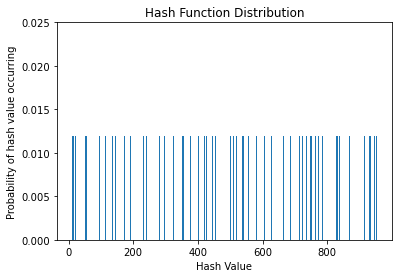

In [86]:
import numpy as np
import matplotlib.pyplot as plt
CBF = CountingBloomFilter(100, 0.01)

#creating a list of strings for testing
text = ["home", "ring", "diamond", "banana", "christmas", "residence", "brother", "sun",
        "kiwi", "near", "one", "beach", "laptop", "finger"]

h_dict = {}

#generating hash values of each of the strings
for item in text:
    h_dict[item] = CBF.hash_cbf(item)

#creating an empty list that will store all the hash values
h_values = []

for index in h_dict:
    for value in h_dict[index]:
        h_values.append(value)

#calculating the probability of each hash value occurring
unique_values, counts = np.unique(h_values, return_counts = True)
prob = counts/len(h_values)

plt.bar(unique_values, prob, width = 2)
plt.title("Hash Function Distribution")
plt.xlabel("Hash Value")
plt.ylabel("Probability of hash value occurring")
plt.show()

## Testing Implementation of Counting Bloom Filter


In [88]:
from collections import deque
import math
from typing import List
from requests import get

class CountingBloomFilter:
    """
    Implements the Counting Bloom Filter which supports:
    
    - search: queries the membership of an element
    - insert: inserts a string to the filter
    - delete: removes a string from the filter
    - hash_cbf: calculating hash values for the elements inserted
    - compute_cbf_arr:
    
    """

    def __init__(self, num_item: int, fpr: float):
        """
        This is a Counting Bloom Filter class that stores the information about the main aspects of CBF: 
        input size, and false positive rate that can be further used to find memory size, initialize bit 
        array, find number of hash functions.
        
        Attributes
        ----------
        num_item : integer
            This is the number of items in Counting Bloom Filter, corresponding to the parameter num_item.
        fpr : integer
            This is the false positive rate of Counting Bloom Filter, corresponding to the parameter fpr.
        """
        self.num_item = num_item
        self.fpr = fpr 
        
        self.memory_size = -1*round((self.num_item * math.log(self.fpr))/(math.log(2))**2) #formula for computing memory_size
        self.cbf_array = [0] * self.memory_size #initializing bit array
        self.num_hashfn = int(round(self.memory_size/self.num_item)*math.log(2))
        self.num_hashfn = min(10, self.num_hashfn) 
        self.prime_list = [127, 149, 179, 197, 233, 257, 283, 313, 379, 401]
        self.primes = self.prime_list[:self.num_hashfn]  #choosing the appropriate number of primes based on the number of hash functions

        
    def hash_cbf(self, item):
        """
        Finding the hash values of the item based on the given primes by multiplying  
        the unicode code of a each character by a prime. Each character is multiplied by a prime as 
        we iterate through the string. Each time we iterate through the string, we multiply by a different prime.
        To get the hash value of the whole string, we add up the hash values of each 
        of the characters and find the remainder after dividing the string hash by a memory size

        Parameters
        ----------
        item: string
            String for which we will be computing k hash values based on k hash functions

        Returns
        ----------
        List
            List containing different hash values of one string depending on the number of hash functions used, 
            and therefore, depending on the number of primes used. 

        """

        hash_indices = [] 
        
        for prime_num in self.primes:
            char_hash = 0
            string_hash = 0
            
            for char in range(len(item)):
                char_hash = ord(item[char]) * prime_num   #hash value of one character
                
                string_hash = string_hash + (char_hash**5) #hash value of the whole string


            hash_indices.append(string_hash % self.memory_size)
        return hash_indices



    def compute_cbf_arr(self, text: List[str], window_size: int):
        """
        

        Parameters
        ----------
        text: list
            String for which we will be computing k hash values based on k hash functions
            
        window_size: int
            Integer that represents the length of the window size

        Returns
        ----------

        """
        
        
        cur_window = deque() #window of length of the input (4 strings) 
        end = 0

        #when we delete
        #we recompute the hash value

        while end < len(text): 
            
            while len(cur_window) < window_size:
                cur_window.append(text[end])
               # print("current window:", cur_window)
                end += 1
            cur_word = "".join(cur_window)

            hash_idxs = self.hash_cbf(cur_word)

            for idx in hash_idxs:
                self.cbf_array[idx] += 1

            cur_window.popleft()
            


    def search(self, input_word: str) -> bool:
        """
        Searches for the given input word in the Counting Bloom Filter (CBF) array by checking indices that 
        correspond to the computed hash values. 

        Parameters:
        ----------
        input_word: str
            The word to search for in the CBF array. 

        Returns: 
        ----------
        bool: 
            True if the word is found, False otherwise. 

        """
        indices = self.hash_cbf("".join(input_word)) 
        count = len(indices)
        for index in indices: 
            if self.cbf_array[index] == 0:
                return False
            else:
                count -= 1
        return count == 0

    
    def insert(self, item):
        """
        Inserts a given item into the Counting Bloom Filter (CBF) array by finding indices that correspond
        to computed hash values and incrementing the values found at those indices by 1. 

        Parameters:
        ----------
        item: str 
            The string we will insert into the CBF array with the use of computed hash values. 

        Returns:
        ----------
        self.cbf_array: List[int]: 
            The updated CBF array where indices corresponding to hash values 
            have the buckets incremented by 1
            
        """

        indeces = self.hash_cbf(item) 

        
        for index in indeces: #for each of the hash value in the list
            self.cbf_array[index] += 1 #find the index that corresponds to the hashvalue and increment by 1
        return self.cbf_array
        

    def delete(self, item):
        """
        Deletes a given item from the Counting Bloom Filter (CBF) array by by finding indices that correspond
        to computed hash values of item and decrementing the values found at those indices by 1. 

        Parameters:
        ----------
        item: str
            The item we need to delete from the CBF array. 

        Raises KeyError: 
        If the item is not found in the CBF array. 

        Returns:
        ----------
        None 
        """
        if self.search(item):
            indeces = self.hash_cbf(item) 

            for index in indeces: 
                self.cbf_array[index] -= 1 #find the index that corresponds to the hashvalue and decrement by 1
        else:
            raise KeyError(f'The item {item} you are searching for is not in the list. There is nothing to delete') 


In [89]:
#Test case for fixed input size of 5, fixed FPR od 0.02 that examines the insert() operation on the word 
# "class" by checking whether the computed array has incremented values at index positions that correspond
# to computed hash values 

num_item = 10
fpr = 0.03
cbf = CountingBloomFilter(num_item, fpr)


print("The size of the CBF bit array is:", cbf.memory_size)
print("Number of hash functions used for computing hash values is:", cbf.num_hashfn)

insertion_1 = cbf.insert("class")
print(insertion_1)

hash_value = cbf.hash_cbf("class")
print(hash_value) 

try:
    assert(insertion_1 == cbf.cbf_array)
    print("✅ Your code returned the expected result!")
except:
    print("🐞 Something is not quite as expected")

The size of the CBF bit array is: 73
Number of hash functions used for computing hash values is: 4
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[25, 23, 7, 15]
✅ Your code returned the expected result!


In [90]:
#Test case for fixed input size of 10, fixed FPR od 0.02 that examines the insert() operation on the word 
#"class" by checking whether the computed array has incremented values at index positions that correspond to 
#computed hash values num_item = 10

num_item = 15
fpr = 0.02
cbf = CountingBloomFilter(num_item, fpr)


print("The size of the CBF bit array is:", cbf.memory_size)
print("Number of hash functions used for computing hash values is:", cbf.num_hashfn)

insertion_1 = cbf.insert("class")

print("CBF array:", insertion_1)
hash_value = cbf.hash_cbf("class")

try:
    assert(insertion_1 == cbf.cbf_array)
    print("✅ Your code returned the expected result!")
except:
    print("🐞 Something is not quite as expected")

The size of the CBF bit array is: 122
Number of hash functions used for computing hash values is: 5
CBF array: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
✅ Your code returned the expected result!


In [91]:
#Test case for search() operation)

num_item = 20
fpr = 0.02
cbf = CountingBloomFilter(num_item, fpr)

insertion_1 = cbf.insert("class")
insertion_2 = cbf.insert("dog")
insertion_3 = cbf.insert("diamond")
insertion_4 = cbf.insert("technique")
insertion_5 = cbf.insert("ring")

searching_non_existent_el = cbf.search("apple")
searching_existent_el = cbf.search("ring")
print(searching_non_existent_el)
print(searching_existent_el)

try:
    assert(searching_non_existent_el  == False)
    print("✅ Your code returned the expected result!")
except:
    print("🐞 Something is not quite as expected")
    
try:
    assert(searching_existent_el  == True)
    print("✅ Your code returned the expected result!")
except:
    print("🐞 Something is not quite as expected")

False
True
✅ Your code returned the expected result!
✅ Your code returned the expected result!


In [92]:
#Performing tests on non-existent string "tomato", and existent string "ring" in array. 
#We are expecting to get KeyError when the item not in the array is tried to be deleted. 
num_item = 5
fpr = 0.02
cbf = CountingBloomFilter(num_item, fpr)

insertion_1 = cbf.insert("class")
insertion_2 = cbf.insert("dog")
insertion_3 = cbf.insert("diamond")
insertion_4 = cbf.insert("technique")
insertion_5 = cbf.insert("ring")


deletion_of_non_exist_el = cbf.delete("tomato")
deletion_of_exist_el = cbf.delete("ring")

print(deletion_of_non_exist_el)
print(deletion_of_exist_el)

KeyError: 'The item tomato you are searching for is not in the list. There is nothing to delete'

In [93]:
# Test case for operating hash_cbf() that computes hash values of the given strings with different length
num_item = 20
fpr = 0.02
cbf = CountingBloomFilter(num_item, fpr)

hash_values_1 = cbf.hash_cbf("class")
hash_values_2 = cbf.hash_cbf("dog")
hash_values_3 = cbf.hash_cbf("diamond")

try:
    assert(hash_values_1  == hash_values_1)
    print("✅ Your code returned the expected result!")
except:
    print("🐞 Something is not quite as expected")
    
    
try:
    assert(hash_values_2 == hash_values_2)
    print("✅ Your code returned the expected result!")
except:
    print("🐞 Something is not quite as expected")
    
    
try:
    assert(hash_values_3 == hash_values_3)
    print("✅ Your code returned the expected result!")
except:
    print("🐞 Something is not quite as expected")
    

✅ Your code returned the expected result!
✅ Your code returned the expected result!
✅ Your code returned the expected result!


## Verifying the effectiveness of your CBF implementation

### a. How does the memory size scale with FPR?

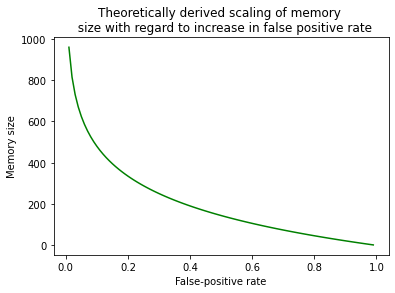

In [94]:
import matplotlib.pyplot as plt 
import numpy as np 

n = 100 #number of elements 

#range of false positive rate 
f = np.arange(0.01, 1, 0.01) 

#memory size corresponding to each false positive rate 
m = -(n * np.log(f))/(np.log(2)**2) 

#plotting relationship between false positive rate and memory size 
plt.plot(f, m, color = "green") 
plt.xlabel('False-positive rate') 
plt.ylabel('Memory size') 
plt.title('Theoretically derived scaling of memory \n  size with regard to increase in false positive rate') 
plt.show()

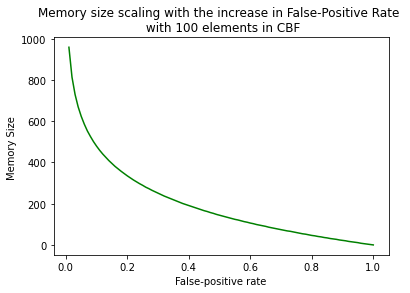

In [95]:
def memory_size_scaling_with_fpr(n):
    fpr = []
    memory_size = []

    for i in range(1, 101):
        f = i/100
        cbf = CountingBloomFilter(num_item = n, fpr = f)
        fpr.append (f)
        memory_size.append(cbf.memory_size) 

    plt.plot (fpr, memory_size, color = "green")
    plt.xlabel ("False-positive rate") 
    plt.ylabel ("Memory Size ")
    plt.title("Memory size scaling with the increase in False-Positive Rate \n with 100 elements in CBF")
    plt.show ()

memory_size_scaling_with_fpr(100)

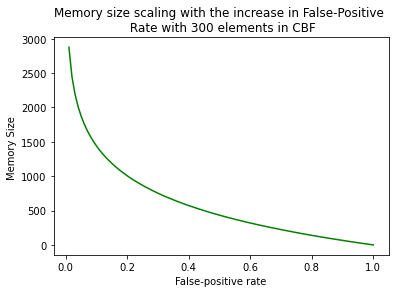

In [96]:
def memory_size_scaling_with_fpr(n):
    fpr = []
    memory_size = []

    for i in range(1, 101):
        f = i/100
        cbf = CountingBloomFilter(num_item = n, fpr = f)
        fpr.append (f)
        memory_size.append(cbf.memory_size) 

    plt.plot (fpr, memory_size, color = "green")
    plt.xlabel ("False-positive rate") 
    plt.ylabel ("Memory Size ")
    plt.title("Memory size scaling with the increase in False-Positive \n Rate with 300 elements in CBF")
    plt.show ()

memory_size_scaling_with_fpr(300)

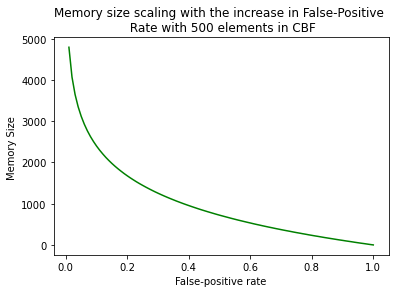

In [97]:
def memory_size_scaling_with_fpr(n):
    fpr = []
    memory_size = []

    for i in range(1, 101):
        f = i/100
        cbf = CountingBloomFilter(num_item = n, fpr = f)
        fpr.append (f)
        memory_size.append(cbf.memory_size) 

    plt.plot (fpr, memory_size, color = "green")
    plt.xlabel ("False-positive rate") 
    plt.ylabel ("Memory Size ")
    plt.title("Memory size scaling with the increase in False-Positive \n Rate with 500 elements in CBF")
    plt.show ()

memory_size_scaling_with_fpr(500)

### b. How does the memory size scale with the number of items stored for a fixed FPR?

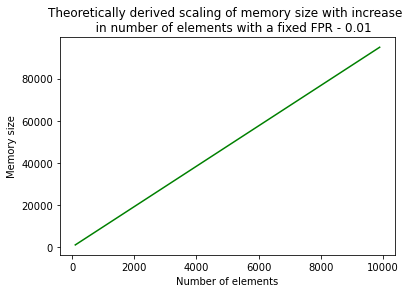

In [98]:
import matplotlib.pyplot as plt 
import numpy as np 

# False positive rate
f = 0.01

#range of number of elements 
n = np.arange(100, 10000, 100) 

#memory size corresponding to each number of elements 
m = -(n * np.log(f))/(np.log(2)**2) 

#plotting number of elements and memory size 
plt.plot(n, m, color = "green") 
plt.xlabel('Number of elements') 
plt.ylabel('Memory size') 
plt.title('Theoretically derived scaling of memory size with increase \n   in number of elements with a fixed FPR - 0.01') 
plt.show()

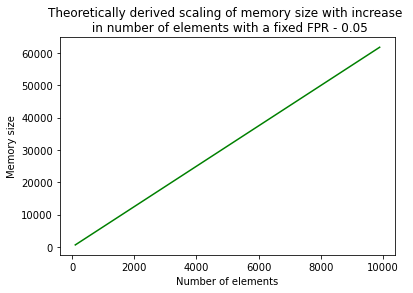

In [99]:
import matplotlib.pyplot as plt 
import numpy as np 

# False positive rate
f = 0.05

#range of number of elements 
n = np.arange(100, 10000, 100) 

#memory size corresponding to each number of elements 
m = -(n * np.log(f))/(np.log(2)**2) 

#plotting number of elements and memory size 
plt.plot(n, m, color = "green") 
plt.xlabel('Number of elements') 
plt.ylabel('Memory size') 
plt.title('Theoretically derived scaling of memory size with increase \n in number of elements with a fixed FPR - 0.05') 
plt.show()

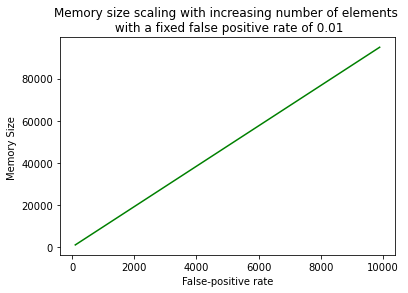

In [100]:
def memory_size_scaling_with_num_el(fpr):
    num_el = []
    memory_size = []

    for i in range(100, 10000, 100):
        num_el.append(i)
        cbf = CountingBloomFilter(num_item = i, fpr = fpr)
        memory_size.append(cbf.memory_size) 

    plt.plot (num_el, memory_size, color = "green")
    plt.xlabel ("False-positive rate") 
    plt.ylabel ("Memory Size ")
    plt.title("Memory size scaling with increasing number of elements \n with a fixed false positive rate of 0.01")
    plt.show ()

memory_size_scaling_with_num_el(0.01)

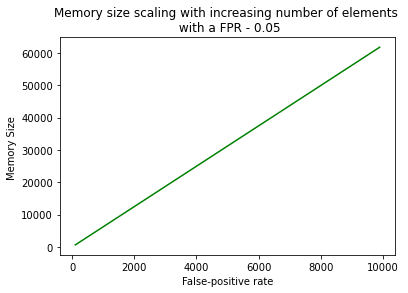

In [101]:
def memory_size_scaling_with_num_el(fpr):
    num_el = []
    memory_size = []

    for i in range(100, 10000, 100):
        num_el.append(i)
        cbf = CountingBloomFilter(num_item = i, fpr = fpr)
        memory_size.append(cbf.memory_size) 

    plt.plot (num_el, memory_size, color = "green")
    plt.xlabel ("False-positive rate") 
    plt.ylabel ("Memory Size ")
    plt.title("Memory size scaling with increasing number of elements \n with a FPR - 0.05")
    plt.show ()

memory_size_scaling_with_num_el(0.05)

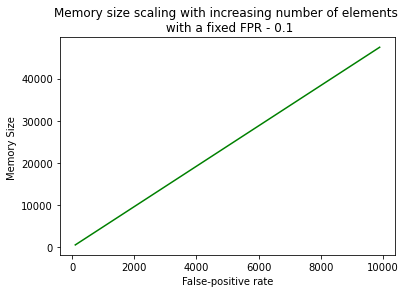

In [102]:
def memory_size_scaling_with_num_el(fpr):
    num_el = []
    memory_size = []

    for i in range(100, 10000, 100):
        num_el.append(i)
        cbf = CountingBloomFilter(num_item = i, fpr = fpr)
        memory_size.append(cbf.memory_size) 

    plt.plot (num_el, memory_size, color = "green")
    plt.xlabel ("False-positive rate") 
    plt.ylabel ("Memory Size ")
    plt.title("Memory size scaling with increasing number of elements \n with a fixed FPR - 0.1")
    plt.show ()

memory_size_scaling_with_num_el(0.1)

### c. How does the actual FPR scale with the number of hash functions?

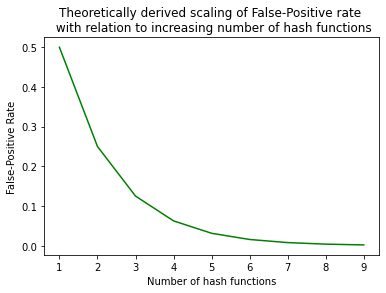

In [103]:
#Theoretical Approach 

def fpr_scaling_with_num_hash_func():
    num_hash_fn = []
    fpr = []

    for k in range(1, 10, 1):
        num_hash_fn.append(k)
        fpr.append(np.exp(-k*np.log(2)))
        
                   
    plt.plot(num_hash_fn, fpr, color = "green")
    plt.xlabel ("Number of hash functions") 
    plt.ylabel ("False-Positive Rate")
    plt.title("Theoretically derived scaling of False-Positive rate \n with relation to increasing number of hash functions")
    plt.show ()

fpr_scaling_with_num_hash_func()

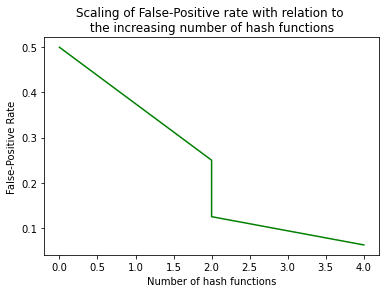

In [104]:
def fpr_scaling_with_num_hash_func():
    num_hash_fn = []
    fpr = []

    for k in range(1, 5, 1):
        cbf = CountingBloomFilter(num_item = 100, fpr = np.exp(-k*np.log(2)))
        num_hash_fn.append(cbf.num_hashfn)
        fpr.append(cbf.fpr)
                   
    plt.plot(num_hash_fn, fpr, color = "green")
    plt.xlabel ("Number of hash functions") 
    plt.ylabel ("False-Positive Rate")
    plt.title("Scaling of False-Positive rate with relation to \n the increasing number of hash functions ")
    plt.show ()

fpr_scaling_with_num_hash_func()

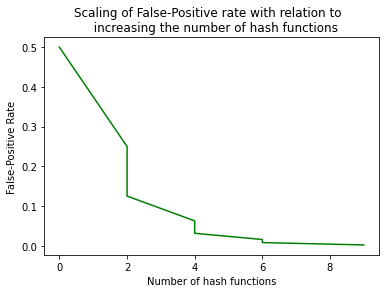

In [105]:
def fpr_scaling_with_num_hash_func_1():
    num_hash_fn = []
    fpr = []

    for k in range(1, 10, 1):
        cbf = CountingBloomFilter(num_item = 100, fpr = np.exp(-k*np.log(2)))
        num_hash_fn.append(cbf.num_hashfn)
        fpr.append(cbf.fpr)
                   
    plt.plot(num_hash_fn, fpr, color = "green")
    plt.xlabel ("Number of hash functions") 
    plt.ylabel ("False-Positive Rate")
    plt.title("Scaling of False-Positive rate with relation to  \n  increasing the number of hash functions")
    plt.show ()
    
fpr_scaling_with_num_hash_func_1()

### d. How does the access time to hashed values scale with the number of items stored in a CBF kept at constant FPR?

In [106]:
# import matplotlib.pyplot as plt
# import time

# num_items = []
# access_times = [] 

# #increasing number of items
# for i in range(1, 3000, 100): 
#     cbf = CountingBloomFilter(i, 0.01)
#     pd = PlagiarismDetector("https://bit.ly/3vUecRn")
#     cbf.compute_cbf_arr(pd.words, 3) #computing bit array 
#     start = time.time() 
#     cbf.search("It is") 
#     end = time.time() 
#     access_time += end - start 
#     access_times.append(access_time) 
#     num_items.append(i) 

# plt.plot(num_items, access_times) 
# plt.xlabel("Number of items stored in the CBF")
# plt.ylabel("Access Time (seconds)")
# plt.title("Access time to hashed values scaling \n with regard to number of items stored in CBF when FPR 0.01")
# plt.show()

In [107]:
# import matplotlib.pyplot as plt
# import time

# num_items = []
# access_times = [] 

# for i in range(1, 3000, 100): 
#     cbf = CountingBloomFilter(i, 0.005)
#     pd = PlagiarismDetector("https://bit.ly/3vUecRn")
#     cbf.compute_cbf_arr(pd.words, 3)
#     start = time.time() 
#     cbf.search("It is")
#     end = time.time() 
#     access_time = end - start 
#     access_times.append(access_time) 
#     num_items.append(i) 

# plt.plot(num_items, access_times) 
# plt.xlabel("Number of items stored in the CBF")
# plt.ylabel("Access Time (seconds)")
# plt.title("Access Time to Hashed Values vs. Number of Items Stored in CBF")
# plt.show()

In [108]:
# import matplotlib.pyplot as plt
# import time

# num_items = []
# access_times = [] 

# for i in range(1, 3000, 100): 
#     cbf = CountingBloomFilter(i, 0.01)
#     pd = PlagiarismDetector("https://bit.ly/3vUecRn")
#     cbf.compute_cbf_arr(pd.words, 3)
#     start = time.time() 
#     cbf.search("It is")
#     end = time.time() 
#     access_time = end - start 
#     access_times.append(access_time) 
#     num_items.append(i) 

# plt.plot(num_items, access_times) 
# plt.xlabel("Number of items stored in the CBF")
# plt.ylabel("Access Time (seconds)")
# plt.title("Access Time to Hashed Values vs. Number of Items Stored in CBF")
# plt.show()

## Testing Plagiarism Detector on small input 

In [109]:
from collections import deque
import math
from typing import List
from requests import get


class CountingBloomFilter:
    """
    Implements the Counting Bloom Filter which supports:
    
    - search: queries the membership of an element
    - insert: inserts a string to the filter
    - delete: removes a string from the filter
    - hash_cbf: calculating hash values for the elements inserted
    - compute_cbf_arr: 
    """

    def __init__(self, num_item: int, fpr: float):
        """
        This is a Counting Bloom Filter class that stores the information about the main aspects of CBF: 
        input size, and false positive rate that can be further used to find memory size, initialize bit 
        array, find number of hash functions.
        
        Attributes
        ----------
        num_item : integer
            number of elements in Counting Bloom Filter, corresponding to the parameter num_item.
        fpr : float
            false positive rate of Counting Bloom Filter, corresponding to the parameter fpr.
        memory_size : integer
            length of bit array of Counting Bloom Filter, corresponding to the parameter memory_size.
        cbf_array : list
            initialized bit array of Counting Bloom Filter, corresponding to the parameter fpr.
        num_hashfn : integer
            number of hash functions, corresponding to the parameter num_hashfn.
        prime_list : list 
            list of prime numbers used for CBF, corresponding to the parameter prime_list
        primes : list
            list of primes numbers used for calculating hash values based on number of hash functions
        """
        self.num_item = num_item
        self.fpr = fpr #false positive rate
        self.memory_size = -1*round((self.num_item * math.log(self.fpr))/(math.log(2))**2)
        self.cbf_array = [0] * self.memory_size
        self.num_hashfn = int(round(self.memory_size/self.num_item)*math.log(2))
        self.num_hashfn = min(10, self.num_hashfn)
        self.prime_list = [127, 149, 179, 197, 233, 257, 283, 313, 379]
        self.primes = self.prime_list[:self.num_hashfn]  #choosing the appropriate number of primes based on the number of hash functions


        
    def hash_cbf(self, item):
        """
        Finding the hash values of the item based on the given primes by finding unicode of each character of 
        the string with ord() and using primes as bases. 
    
        Parameters
        ----------
        item: string
            String for which we will be computing k hash values based on k hash functions

        Returns
        ----------
        List
            List containing different hash values of one string depending on the number of hash functions used, 
            and therefore, depending on the number of primes used. 

        """

        hash_indices = [] 
        
        for prime_num in self.primes:
            char_hash = 0
            string_hash = 0

            for char in range(len(item)):
                char_hash = (ord(item[char]) * prime_num**(len(item)-char-1))   #hash value of one character
                string_hash = string_hash + char_hash #hash value of the whole string

            hash_indices.append(string_hash % self.memory_size)
        return hash_indices
    
  
  
    def compute_cbf_arr(self, text: List[str], window_size: int):
        """
        Uses a deque to create a window of the specified size and computes the hash values of each of the string. 
        The function then adds the computed hash values to the array and increment values at index positions 

        Parameters
        ----------
        text: list
            list of strings that will be used for creating windows to compute hash values 
            
        window_size: int
            integer that represents the sliding window size; number of strings in the window

        Returns
        ----------
        None

        """
          
        cur_window = deque() #window of length of the input (3 strings ) 
        end = 0

        while end < len(text): 
            while len(cur_window) < window_size:
                cur_window.append(text[end])
                end += 1
            cur_word = "".join(cur_window)
            hash_idxs = self.hash_cbf(cur_word)
            for idx in hash_idxs:
                self.cbf_array[idx] += 1
            cur_window.popleft()
        

    def search(self, input_word: str) -> bool:
        """
        Searches for the given input word in the Counting Bloom Filter (CBF) array by checking indices that 
        correspond to the computed hash values. 

        Parameters:
        ----------
        input_word: str
            The word/phrase to search for in the CBF array. 

        Returns: 
        ----------
        bool: 
            True if the word is found, False otherwise. 
            True occurs when all the values at index positions are greater than 0, False occurs when one of the 
            values at index positions (hash values) is equal to 0. 

        """

        indices = self.hash_cbf("".join(input_word)) 
        count = len(indices)
        for index in indices: #getting all the hash values of the item
            if self.cbf_array[index] == 0:
                return False
            else:
                count -= 1
        return count == 0

    
    def insert(self, item):
        """
        Inserts a given item into the Counting Bloom Filter (CBF) array by finding indices that correspond
        to computed hash values and incrementing the values found at those indices by 1. 

        Parameters:
        ----------
        item: str 
            The string we will insert into the CBF array with the use of computed hash values. 

        Returns:
        ----------
        self.cbf_array: List[int]: 
            The updated CBF array where indices corresponding to hash values 
            have the buckets incremented by 1.
            
        """

        indeces = self.hash_cbf(item) 

        
        for index in indeces: #for each of the hash value in the list
            self.cbf_array[index] += 1 #find the index that corresponds to the hashvalue and increment by 1
        return self.cbf_array
        

    def delete(self, item):
        """
        Deletes a given item from the Counting Bloom Filter (CBF) array by by finding indices that correspond
        to computed hash values of item and decrementing the values found at those indices by 1. 

        Parameters:
        ----------
        item: str
            The item we need to delete from the CBF array. 

        Raises KeyError: 
        If the item is not found in the CBF array. 

        Returns:
        ----------
        None 
        """

        if self.search(item):
            indeces = self.hash_cbf(item) 

            for index in indeces: #for each of the hash value in the list
                self.cbf_array[index] -= 1 #find the index that corresponds to the hashvalue and decrement by 1
        else:
            raise KeyError(f'The item {item} you are searching for is not in the list. There is nothing to delete') 


num_item = 10
fpr = 0.02
cbf = CountingBloomFilter(num_item, fpr)

class PlagiarismDetector:
    """
    This class implements a Plagiarism Detector using a Counting Bloom Filter that supports:
    
    - split_text_to_words: Cleans the text data 
    - check_phrase_for_plagiarism: Checks phrase of specified length, which is number of words for plagiarism 
    - get_all_windows: Creates a list of all the windows of strings of the specified length in the text
    - check_for_plagiarism: Finds the percent of plagiarism based on the number of matches between two texts
    
    """     

    def __init__(self, url, test_words):
        
        """
        This is a Plagiarism Detector class using Counting Bloom Filter that takes as input several attributes:
        
        Attributes
        ----------
        url: str
            Input text (inserted as url) that will be used for checking plagiarism between two pieces of text
        
        test_words: list
            List of words
            
        bloom_filters: dict
            dictionary where key corresponds to the number of words (windows of certain size), 
            and value corresponds to the bit array with the corresponding values at indices 
           
        """
        self.bloom_filters = {}
        self.url = url
        self.test_words = test_words


    def split_text_to_words(self, url: str) -> List[str]:
        bad_chars = [';', ',', '.', '?', '!', '_', '[', ']', '(', ')', '*']
        data = get(url).text
        data = ''.join(c for c in data if c not in bad_chars)
        data_without_newlines = ''.join(c if (c not in ['\n', '\r', '\t']) else " " for c in data)
        data_just_words = [word for word in data_without_newlines.split(" ") if word != ""]
        data_just_words_lower_case = [word.lower() for word in data_just_words]
        return data_just_words_lower_case

    def split_words_simple(self, text: str):
        return text.split(" ")
    
    
    def check_phrase_for_plagiarism(self, input_: str):
        input_words = self.split_words_simple(input_) #phrase is an input:
        num_words = len(input_words)
        if self.bloom_filters.get(num_words) is None: #if key is not in the dictionary
            bloom_filter_for_given_size = CountingBloomFilter(10, 0.02) 

            bloom_filter_for_given_size.compute_cbf_arr(self.test_words, num_words) #finding aray of indices 
            self.bloom_filters[num_words] = bloom_filter_for_given_size #inserting this key-value pair in dictionary
        return self.bloom_filters[num_words].search(input_words) 



    def get_all_windows(self, text: List[str], window_size: int):
        windows = []
        cur_window = deque() 
        end = 0

        while end < len(text): 
            while len(cur_window) < window_size:
                cur_window.append(text[end])
                end += 1
            windows.append("".join(cur_window))
            cur_window.popleft()
        return windows 


    def check_for_plagiarism(self, plag_text: str):
        words = self.split_words_simple(plag_text)
        if (len(words) < 4):
            return self.get_all_windows(words, 3)
        all_words_of_len_4 = self.get_all_windows(words, 4)
        print(all_words_of_len_4)
        
        count = 0
        for word in all_words_of_len_4:
            
            if self.check_phrase_for_plagiarism(word):
                count += 1
        
        return count / len(all_words_of_len_4)


detect = PlagiarismDetector("https://bit.ly/39MurYb", ["here", "is", "some", "text", "that", "we", "found"])


In [110]:
#Test 1: Finding plagiarism between given input: "here", "is", "some", "text", "that", "we", "found", 
# and phrase "some text that we"

phrase_1 = "some text that we"
test_1 = detect.check_phrase_for_plagiarism("some text that we")

print(f'It is {test_1} that the phrase: "{phrase_1}" is in the text. ')
try:
    assert(test_1 == True)
    print("✅ Your code returned the expected result!\n")
except:
    print("🐞 Something is not quite as expected")

It is True that the phrase: "some text that we" is in the text. 
✅ Your code returned the expected result!



In [111]:
#Test 2: Finding plagiarism between given input: "here", "is", "some", "text", "that", "we", "found", 
# and phrase "some text not that"

phrase_2 = "some text not that"
test_2 = detect.check_phrase_for_plagiarism("some text not that")

print(f'It is {test_2} that the phrase: "{phrase_2}" is in the text. ')

try:
    assert(test_2 == False)
    print("✅ Your code returned the expected result!\n")
except:
    print("🐞 Something is not quite as expected")
    

It is False that the phrase: "some text not that" is in the text. 
✅ Your code returned the expected result!



In [112]:
#Test 3: Finding plagiarism between given input: "here", "is", "some", "text", "that", "we", "found", 
# and phrase "some text that found"

phrase_3 = "some text that found"
test_3 = detect.check_phrase_for_plagiarism("some text that found")

print(f'It is {test_3} that the phrase: "{phrase_3}" is in the text. ') 

try:
    assert(test_3 == False)
    print("✅ Your code returned the expected result!\n")
except:
    print("🐞 Something is not quite as expected")


It is False that the phrase: "some text that found" is in the text. 
✅ Your code returned the expected result!



In [113]:
#Test 4: Finding plagiarism between given input: "here", "is", "some", "text", "that", "we", "found", 
# and phrase "here is some"

phrase_4 = "here is some"
test_4 = detect.check_phrase_for_plagiarism("here is some")
    
print(f'It is {test_4} that the phrase: "{phrase_4}" is in the text. ')       
     
try:
    assert(test_4 == True)
    print("✅ Your code returned the expected result!")
except:
    print("🐞 Something is not quite as expected")


It is True that the phrase: "here is some" is in the text. 
✅ Your code returned the expected result!


### Other Algorithmic Approach to Detect Plagiarism: Brute Force


In [114]:
def split_text_to_phrases(url: str) -> List[str]:
    '''
    Cleans the text data

    Parameters
    ----------
    url : string
        The URL for the txt file.

    Returns
    -------
    data_just_phrases_lower_case: list
        List of "cleaned-up" phrases sorted by the order they appear in the original file.
    '''
    bad_chars = [';', ',', '.', '?', '!', '_', '[', ']', '(', ')', '*']
    data = get(url).text
    data = ''.join(c for c in data if c not in bad_chars)
    data_without_newlines = ''.join(c if (c not in ['\n', '\r', '\t']) else " " for c in data)
    data_just_words = [word for word in data_without_newlines.split(" ") if word != ""]
    data_just_phrases = []

    for index in range(0, len(data_just_words)-3, 3):
        #creating phrases of length 4 words
        phrase = data_just_words[index] + " " + data_just_words[index+1] + " " + data_just_words[index+2] + " " + data_just_words[index+3]
        data_just_phrases.append(phrase)
    data_just_phrases_lower = [phrase.lower() for phrase in data_just_phrases]
    return data_just_phrases_lower
    

def plagiarism_detector(text_1, text_2):
    '''
    Detects plagiarism 
    
    Parameters
    ----------
    text_1 : string
        The URL for the txt file.
        
    text_2 : string
        The URL for the txt file.

    Returns
    -------
    plagiairsm_percent: float
        Percentage of plagiarized phrases between two texts
    '''
    
    #creating set of phrases from both texts 
    phrases_from_text1 = split_text_to_phrases(text_1) 
    phrases_from_text2 = split_text_to_phrases(text_2) 
  
    
    plagiarized_phrases = set() #initializing set to store plagiarized phrases as it does not store duplicates
  
    for phrase in phrases_from_text1: 
        for phrase_ in phrases_from_text2: 
            if phrase == phrase_: 
                plagiarized_phrases.add(phrase) 

    #calculating percent of plagiarized phrases 
    plagiarism_percent = (len(plagiarized_phrases)/(len(phrases_from_text1) + len(phrases_from_text2))) * 100
  
    return plagiarism_percent 

print("The plagiarism percentage between the first text and second text is", plagiarism_detector("https://bit.ly/3we1QCp", "https://bit.ly/39MurYb"), "%")

print("The plagiarism percentage between the first text and third text is", plagiarism_detector("https://bit.ly/3vUecRn", "https://bit.ly/39MurYb"), "%" )

print("The plagiarism percentage between the second text and third text is", plagiarism_detector("https://bit.ly/3we1QCp", "https://bit.ly/3vUecRn") , "%")


The plagiarism percentage between the first text and second text is 0.0 %
The plagiarism percentage between the first text and third text is 0.0 %
The plagiarism percentage between the second text and third text is 0.0 %


### Runtime of Brute Force Approach to Detect Plagiarism 

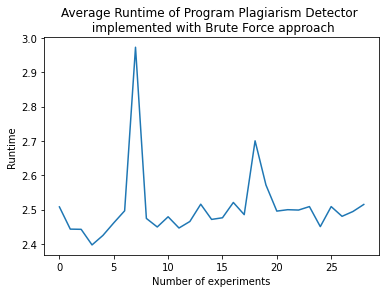

In [115]:
import time 
import matplotlib.pyplot as plt 
runtime = []
 
for i in range(1, 30):
    start = time.time()
    total_time = 0
    
    #finding plagiarism percentage
    for _ in range(10):
        text1 = "https://bit.ly/3we1QCp"
        text2 = "https://bit.ly/39MurYb"
        percentage = plagiarism_detector(text1, text2)
        end = time.time()
        total_time += (end - start)
    #calculating and storing time
    average_time = total_time/30
    runtime.append(average_time)

plt.plot(runtime)
plt.xlabel('Number of experiments') 
plt.ylabel('Runtime') 
plt.title('Average Runtime of Program Plagiarism Detector \n implemented with Brute Force approach') 
plt.show()

### Comparison of Average runtime in seconds between Plagiarism Detector using CBF and Brute Force 

In [41]:

import time
import random

#getting average runtime of Plagiarism Detetctor with CBF 
def get_avg_runtime():
    total_runtime = 0
    for i in range(50):
        start = time.time()
        detection = PlagiarismDetector('https://bit.ly/39MurYb')
        detection.check_for_plagiarism("https://bit.ly/3we1QCp")
      
        end = time.time()
        total_runtime += end - start
    avg_runtime = total_runtime/50
  
    print("Average runtime of the program Plagiairsm Detector utilizing CBF is: {} seconds".format(avg_runtime))
get_avg_runtime()

Average runtime of the program Plagiairsm Detector utilizing CBF is: 2.334519453048706 seconds


In [42]:
import time
import random

#getting average runtime of Plagiarism Detetctor with Brute Force 
def get_avg_runtime():
    total_runtime = 0
    for i in range(50):
        start = time.time()
        detection = plagiarism_detector('https://bit.ly/39MurYb', "https://bit.ly/3we1QCp")
        end = time.time()
        total_runtime += end - start
    avg_runtime = total_runtime/50
  
    print("Average runtime of the brute-force approach is: {} seconds".format(avg_runtime))
get_avg_runtime()

Average runtime of the brute-force approach is: 1.3563573789596557 seconds


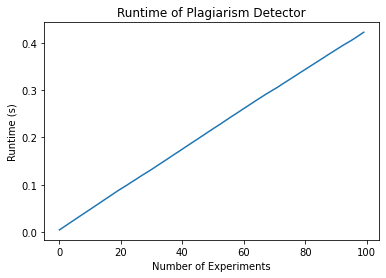

In [47]:
avg_runtime = []
def aver_runtime():
    total_time = 0

    for i in range(100): 
        start = time.process_time()
        plagiarism_detector('https://bit.ly/39MurYb', 'https://bit.ly/3we1QCp')
        total_time += (time.process_time() - start)

        avg_runtime.append(total_time/100)

    plt.plot(avg_runtime)
    plt.xlabel('Number of Experiments')
    plt.ylabel('Runtime (s)')
    plt.title('Runtime of Plagiarism Detector')
    plt.show()
aver_runtime()